In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the training and testing datasets
train_data = pd.read_csv('/content/drive/MyDrive/Google_Stock_Price_Train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Google_Stock_Price_Test.csv')

# Retain the 'Date' column separately for future use
train_dates = train_data['Date']
test_dates = test_data['Date']

# Remove commas and convert numeric columns to float for both datasets
for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
    train_data[column] = train_data[column].astype(str).str.replace(',', '').astype(float)
    test_data[column] = test_data[column].astype(str).str.replace(',', '').astype(float)

# Normalize the data (excluding the 'Date' column)
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale training data
train_numeric_data = train_data[['Open', 'High', 'Low', 'Close', 'Volume']]
scaled_train_data = scaler.fit_transform(train_numeric_data)
scaled_train_df = pd.DataFrame(scaled_train_data, columns=train_numeric_data.columns)

# Scale testing data using the same scaler
test_numeric_data = test_data[['Open', 'High', 'Low', 'Close', 'Volume']]
scaled_test_data = scaler.transform(test_numeric_data)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=test_numeric_data.columns)

# Add the 'Date' column back to scaled data
scaled_train_df['Date'] = train_dates
scaled_test_df['Date'] = test_dates

# Split the training data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(
    scaled_train_df.drop(columns=['Close', 'Date']),  # Features (exclude 'Close' and 'Date')
    scaled_train_df['Close'],                        # Target (predict 'Close' price)
    test_size=0.2,                                   # 20% for validation
    random_state=9                                  # Ensures reproducibility
)

# Define test features by dropping 'Close' (target) and 'Date'
test_features = scaled_test_df.drop(columns=['Close', 'Date'])

# Reshape training, validation, and testing data to include a time step dimension
train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.values.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_features = test_features.values.reshape((test_features.shape[0], 1, test_features.shape[1]))

# Print shapes of datasets after reshaping
print("Training features shape (after reshaping):", train_X.shape)
print("Validation features shape (after reshaping):", val_X.shape)
print("Testing features shape (after reshaping):", test_features.shape)
print("Training target shape:", train_y.shape)
print("Validation target shape:", val_y.shape)

Training features shape (after reshaping): (1006, 1, 4)
Validation features shape (after reshaping): (252, 1, 4)
Testing features shape (after reshaping): (20, 1, 4)
Training target shape: (1006,)
Validation target shape: (252,)


In [4]:
# Define Vanilla RNN
def build_rnn(input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))  # Output layer for predicting 'Close' price
    model.compile(optimizer='adam', loss='mse')
    return model

In [5]:
# Define GRU
def build_gru(input_shape):
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))  # Output layer for predicting 'Close' price
    model.compile(optimizer='adam', loss='mse')
    return model


In [6]:
# Define LSTM
def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))  # Output layer for predicting 'Close' price
    model.compile(optimizer='adam', loss='mse')
    return model

In [7]:
# Define a function to train the models
def train_model(model, train_X, train_y, val_X, val_y, epochs=50, batch_size=32):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        train_X, train_y,
        validation_data=(val_X, val_y),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    return history



In [8]:
# Build models
rnn_model = build_rnn((train_X.shape[1], train_X.shape[2]))
gru_model = build_gru((train_X.shape[1], train_X.shape[2]))
lstm_model = build_lstm((train_X.shape[1], train_X.shape[2]))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Train Vanilla RNN
print("Training Vanilla RNN...")
rnn_history = train_model(rnn_model, train_X, train_y, val_X, val_y)

Training Vanilla RNN...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0949 - val_loss: 0.0556
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0496 - val_loss: 0.0518
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0476 - val_loss: 0.0485
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0426 - val_loss: 0.0463
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0430 - val_loss: 0.0450
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0418 - val_loss: 0.0441
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0434 - val_loss: 0.0434
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0400 - val_loss: 0.0420
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0387 - val_loss: 0.0424
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0368 - val_loss: 0.0406
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0387 - val_loss: 0.0409
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

In [10]:
# Train GRU
print("Training GRU...")
gru_history = train_model(gru_model, train_X, train_y, val_X, val_y)

Training GRU...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.1162 - val_loss: 0.0567
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0477 - val_loss: 0.0512
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0484 - val_loss: 0.0503
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0450 - val_loss: 0.0491
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0439 - val_loss: 0.0479
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0439 - val_loss: 0.0468
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0416 - val_loss: 0.0453
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0434 - val_loss: 0.0460
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0393 - val_loss: 0.0434
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0384 - val_loss: 0.0432
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0389 - val_loss: 0.0422
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

In [11]:
# Train LSTM
print("Training LSTM...")
lstm_history = train_model(lstm_model, train_X, train_y, val_X, val_y)

Training LSTM...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.1291 - val_loss: 0.0926
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0733 - val_loss: 0.0583
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0541 - val_loss: 0.0548
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0450 - val_loss: 0.0535
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0516 - val_loss: 0.0525
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0450 - val_loss: 0.0514
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0474 - val_loss: 0.0506
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0459 - val_loss: 0.0500
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0439 - val_loss: 0.0489
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0433 - val_loss: 0.0480
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0425 - val_loss: 0.0475
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - los

In [13]:
# Extract the actual 'Close' prices for the test set
test_target = scaled_test_df['Close'].values
# Define a function to evaluate models with extended metrics
def evaluate_model(model, test_features, test_target):
    predictions = model.predict(test_features).flatten()
    mse = np.mean((test_target - predictions) ** 2)
    mae = np.mean(np.abs(test_target - predictions))
    mape = np.mean(np.abs((test_target - predictions) / test_target)) * 100
    return predictions, mse, mae, mape

# Define a function to calculate regression metrics
def regression_metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, mae, mape

# Evaluate models and calculate metrics
print("Evaluating Vanilla RNN...")
rnn_predictions, rnn_mse, rnn_mae, rnn_mape = evaluate_model(rnn_model, test_features, test_target)

print("Evaluating GRU...")
gru_predictions, gru_mse, gru_mae, gru_mape = evaluate_model(gru_model, test_features, test_target)

print("Evaluating LSTM...")
lstm_predictions, lstm_mse, lstm_mae, lstm_mape = evaluate_model(lstm_model, test_features, test_target)

# Print results for all models
print("\nEvaluation Results:")
print(f"Vanilla RNN - MSE: {rnn_mse}, MAE: {rnn_mae}, MAPE: {rnn_mape}%")
print(f"GRU - MSE: {gru_mse}, MAE: {gru_mae}, MAPE: {gru_mape}%")
print(f"LSTM - MSE: {lstm_mse}, MAE: {lstm_mae}, MAPE: {lstm_mape}%")

Evaluating Vanilla RNN...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
Evaluating GRU...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Evaluating LSTM...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step

Evaluation Results:
Vanilla RNN - MSE: 0.003104252993309229, MAE: 0.052146563814360024, MAPE: 11.957044243926463%
GRU - MSE: 0.0017930198499033312, MAE: 0.040131225320931205, MAPE: 9.22648168756768%
LSTM - MSE: 0.003140723505690757, MAE: 0.05320745769464565, MAPE: 12.203777452067852%


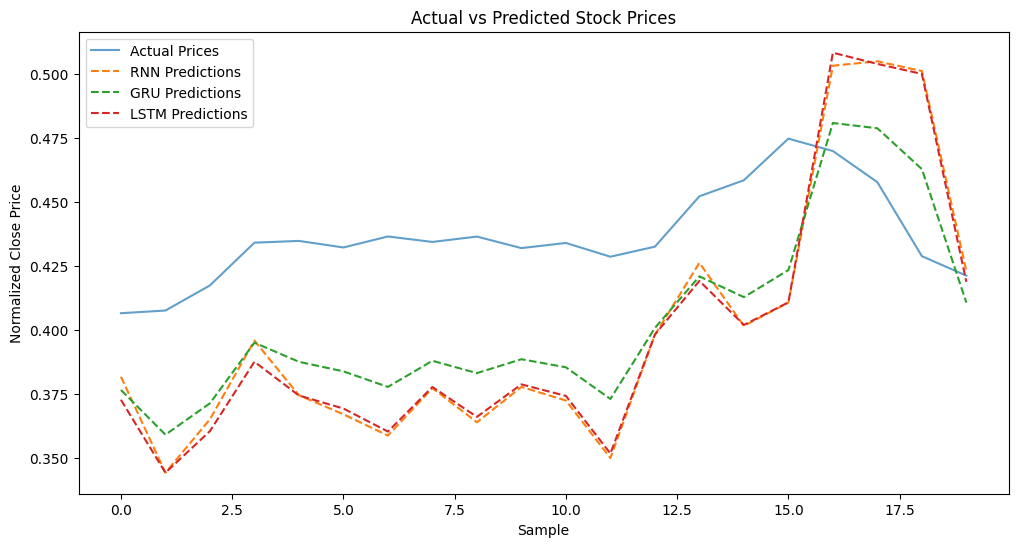

In [14]:
import matplotlib.pyplot as plt

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(test_target, label='Actual Prices', alpha=0.7)
plt.plot(rnn_predictions, label='RNN Predictions', linestyle='dashed')
plt.plot(gru_predictions, label='GRU Predictions', linestyle='dashed')
plt.plot(lstm_predictions, label='LSTM Predictions', linestyle='dashed')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Sample')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.show()

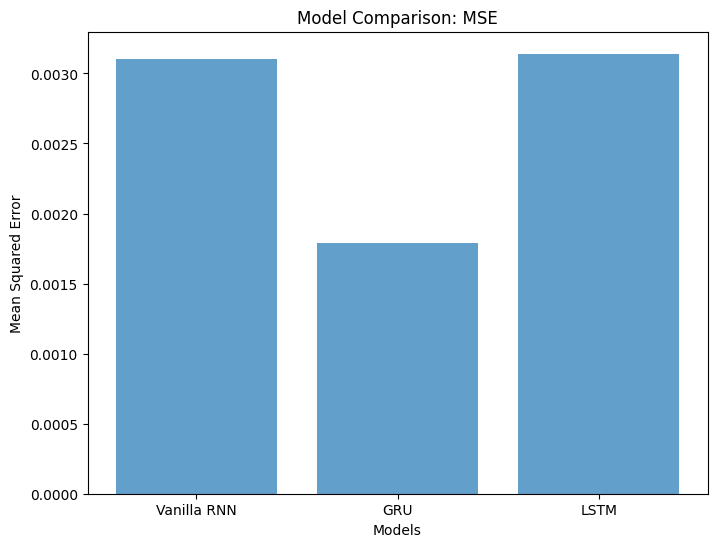

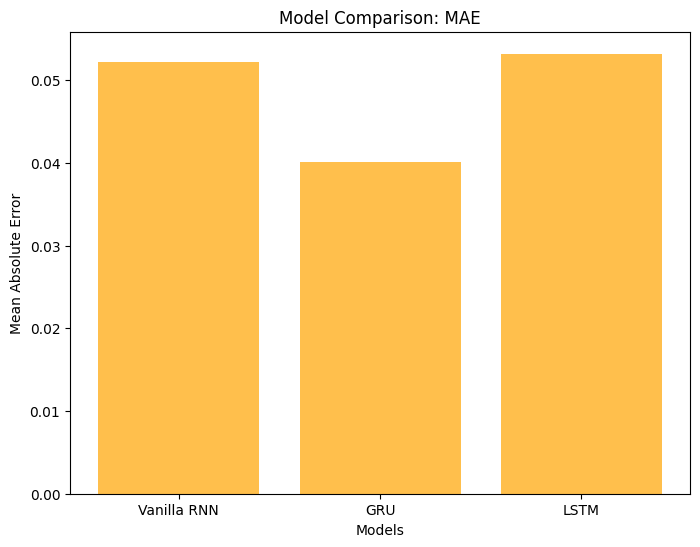

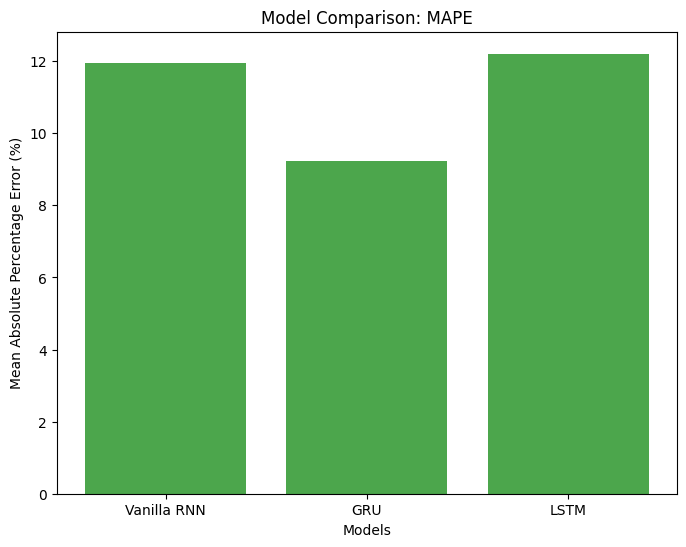

In [15]:
# Metrics for all models
models = ['Vanilla RNN', 'GRU', 'LSTM']
mse_values = [rnn_mse, gru_mse, lstm_mse]
mae_values = [rnn_mae, gru_mae, lstm_mae]
mape_values = [rnn_mape, gru_mape, lstm_mape]

# Plot MSE
plt.figure(figsize=(8, 6))
plt.bar(models, mse_values, alpha=0.7)
plt.title('Model Comparison: MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('Models')
plt.show()

# Plot MAE
plt.figure(figsize=(8, 6))
plt.bar(models, mae_values, alpha=0.7, color='orange')
plt.title('Model Comparison: MAE')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Models')
plt.show()

# Plot MAPE
plt.figure(figsize=(8, 6))
plt.bar(models, mape_values, alpha=0.7, color='green')
plt.title('Model Comparison: MAPE')
plt.ylabel('Mean Absolute Percentage Error (%)')
plt.xlabel('Models')
plt.show()

In [16]:
import pandas as pd

# Assuming the following variables contain your data:
# - test_target: Actual prices from the test dataset
# - rnn_predictions: Predicted prices by the Vanilla RNN model
# - gru_predictions: Predicted prices by the GRU model
# - lstm_predictions: Predicted prices by the LSTM model

# Convert the test_target and predictions to their original scale if they are normalized
# Uncomment the following lines if scaling is applied:
# test_target = scaler.inverse_transform(test_target.reshape(-1, 1)).flatten()
# rnn_predictions = scaler.inverse_transform(rnn_predictions.reshape(-1, 1)).flatten()
# gru_predictions = scaler.inverse_transform(gru_predictions.reshape(-1, 1)).flatten()
# lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1)).flatten()

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    "Actual Price": test_target,
    "Vanilla RNN Predicted Price": rnn_predictions,
    "GRU Predicted Price": gru_predictions,
    "LSTM Predicted Price": lstm_predictions
})

# Display the DataFrame
print(comparison_df)

# Save the DataFrame to a CSV file for further analysis if needed
comparison_df.to_csv("predicted_vs_actual_prices.csv", index=False)

# Display the first few rows of the DataFrame for verification
comparison_df.head()

    Actual Price  Vanilla RNN Predicted Price  GRU Predicted Price  \
0       0.406461                     0.381614             0.376443   
1       0.407508                     0.344111             0.358964   
2       0.417320                     0.364970             0.371235   
3       0.434037                     0.395754             0.394937   
4       0.434726                     0.374374             0.387459   
5       0.432162                     0.366932             0.383724   
6       0.436462                     0.358616             0.377638   
7       0.434326                     0.377174             0.387857   
8       0.436421                     0.363817             0.383039   
9       0.431914                     0.377637             0.388472   
10      0.433926                     0.372318             0.385318   
11      0.428552                     0.349846             0.372927   
12      0.432479                     0.398008             0.400698   
13      0.452173    

,Actual Price,Vanilla RNN Predicted Price,GRU Predicted Price,LSTM Predicted Price
0,0.406461,0.381614,0.376443,0.372606
1,0.407508,0.344111,0.358964,0.344094
2,0.417320,0.364970,0.371235,0.360360
3,0.434037,0.395754,0.394937,0.387478
4,0.434726,0.374374,0.387459,0.374281
